In [36]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import null_space
from IPython.display import clear_output
from sklearn.linear_model import LassoLars
import random
import warnings
warnings.filterwarnings('ignore')

Load the dataset

In [37]:
#X = pd.read_csv("../Data/data.csv").drop(['Unnamed: 0'], axis = 1).to_numpy()
#y = pd.read_csv("../Data/labels.csv").drop(['Unnamed: 0'], axis = 1).to_numpy()

In [38]:
#X_proto = X[1:101, 1:201]
#y_proto = y[1:101]

In [39]:
X_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1).drop(['Class'],axis=1).to_numpy()
y_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1)['Class'].to_numpy()

y_small = preprocessing.LabelEncoder().fit_transform(y_small)

In [34]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = np.abs(array.flatten())
    #if np.amin(array) < 0:
        # Values cannot be negative:
        #array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [35]:
class PCAObject:
    def __init__(self, PCs, X, label):
        assert len(PCs) == min(X.shape[0],X.shape[1]), "Need all the principal components!"
        self.pcs = PCs
        self.X = StandardScaler().fit_transform(X)
        self.cov = np.cov(self.X.T)
        self.label = label
        
        self._calcExpVar()
        self._calcNonZeroLoads()
        self._calcGini()
        self._calcWgtGini()    
    
    def _calcExpVar(self):
        tot_var = np.sum(np.diag(self.cov))
        self.ev = np.diag(self.pcs @ np.cov(self.X.T) @ self.pcs.T)/np.linalg.norm(self.pcs, axis = 1)**2
        self.ev[np.isnan(self.ev)] = 0
        self.pev = [ev/tot_var for ev in self.ev]
        self.cev = np.cumsum(np.flip(np.sort(self.pev)))
        
    def _calcNonZeroLoads(self):
        self.nonZeroLoads = [np.count_nonzero(pc) for pc in self.pcs]
        
    def _calcGini(self):
        self.gini = [gini(i) for i in self.pcs]
        
    def _calcWgtGini(self):
        self.wgtGini = np.sum([gini * pev for gini, pev in zip(self.gini, self.pev)])
        
    def plotNonZeroLoadtoPEV(self):
        plt.plot(self.nonZeroLoads, self.pev, label=self.label)
        plt.xlabel('Number of non-zero loadings')
        plt.xscale('log')
        plt.ylabel('Percentage of explained variance (PEV)')
        plt.legend()
        plt.title('Percentage of explained variance (PEV) vs non-zero loadings')
        
    def plotCEV(self):
        x = np.arange(len(self.pcs))
        
        plt.plot(x, np.sort(self.cev), label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Cumulative explained variance (CEV)')
        plt.legend()
        plt.title('Cumulative explained variance (CEV)')
        
    def plotSparsitytoEV(self,k): #k is which PC you want to plot
        plt.scatter(self.gini[k], self.ev[k], label = self.label)
        plt.xlabel('Sparsity of PC '+str(k+1))
        plt.ylabel('Explained Variance of PC '+str(k+1))
        plt.xlim((0,1))
        plt.legend()
        plt.title('Sparsity of PC versus Expained Variance of PC '+str(k+1))

In [40]:
def reg_PCA(X, k = "all"): 
    """
    function takes an n x p feature matrix
    returns two arrays:
    - array with percentage of explained variance in first k principal directions (k_comp x 1)
    - array with principal directions (k_comp x p)
    """
    X = StandardScaler().fit_transform(X)
    if k == "all": k = min(X.shape[0],X.shape[1])
    pca = PCA(n_components = k)
    pca.fit(X)
    PEVs = pca.explained_variance_ratio_
    prin_comp = pca.components_
    EVs = pca.explained_variance_
    
    return PEVs, prin_comp, EVs

In [41]:
def threshold_PCA(X, thresh = 1e-1, k = "all"):
    """
    function takes
    - X: n x p feature matrix
    - thresh: float representing this non-zero cutoff
    - k: integer for number of principal directions wanted
    returns one array:
    - array with principal components in its columns (k x p)
    """
    if k == "all": k = min(X.shape[0],X.shape[1])

    pcs = reg_PCA(X)[1]
    pcs = (np.abs(pcs) >= thresh).astype(int) * pcs
    
    return pcs[:k]

In [42]:
def nonZeroLoad_PCA(X,j, k = "max"):
    """
    function takes
    - X: n x p feature matrix
    - j: integer for number of non-zero loadings,
    - k: integer for number of principal directions wanted
    returns three arrays:
    - array with percentages of explained variance in first k principal directions (k x 1)
    - array with principal directions (k x p)
    - array with explained variances
    """   
    X_scaled = StandardScaler().fit_transform(X)
    if k == "all": k = min(X.shape[0],X.shape[1])
    
    PCA_PEV, PCA_PC, PCA_EV = reg_PCA(X,min(X.shape[0],X.shape[1]))
    
    total_var = sum(PCA_EV)
    
    thresh_PCA_PC = np.empty((0,PCA_PC.shape[1]))
    thresh_PCA_PEV = []
    thresh_PCA_EV = []
    
    PCA_PC_sorted = np.sort(np.absolute(PCA_PC), axis = 1)
    for m in range(k):
        thresh = PCA_PC_sorted[m][-j]
        thresh_PC = (np.absolute(PCA_PC[m]) >= thresh).astype(int)*PCA_PC[m]
        thresh_PCA_PC = np.vstack((thresh_PCA_PC, thresh_PC))
    
    return thresh_PCA_PC

In [43]:
def SimpTrans(r, s, k, X_scaled):
    """
    function takes
    - Two directions r and s to transform
    - An integer k that restricts the possible directions
    - The scaled data matrix X
    returns two vectors and three floats
    - Two new directions r and s
    - Two floats representing the variances explained by the new directions r and s
    - One float representing the covariance of the new directions r and s
    """
    # Calculate the covariance matrix for the two directions
    cov = np.vstack((r,s)) @ np.cov(X_scaled.T) @ np.vstack((r,s)).T
    v_old_r, v_old_s, v_old_rs = cov[0,0], cov[1,1], cov[0,1]
    
    # Get a list of all possible betas
    poss_beta1 = [i/2**k for i in range(-2**k, 2**k+1, 1)]
    poss_beta2 = [2**k/i for i in range(-2**k, 2**k+1, 1) if i != 0]
    poss_beta = np.sort(list(set(poss_beta1 + poss_beta2)))
    
    # Calculate the norms of the two directions
    l2_r, l2_s = np.linalg.norm(r)**2, np.linalg.norm(s)**2
    
    # Find the beta that maximizes the variance in the normalized
    # direction of the first new principal component
    v_r, v_s, v_rs = cov[0,0], cov[1,1], cov[0,1]
    a = l2_s*v_rs
    b = np.sqrt(l2_r*l2_s)*(v_r - v_s)
    c = l2_r*v_rs
    discr = b**2 - 4*a*c
    beta_star = (-b+np.sqrt(discr))/(2*a)
    
    # Select beta from possible values that's closest to the optimal value
    beta_star = min(list(poss_beta), 
                    key = lambda x:abs(x-beta_star))
    
    # Calculate the two new directions
    if abs(beta_star) <= 1:
        r_new = 2**k*r + 2**k*beta_star*s
        s_new = 2**k*beta_star*l2_s*r - 2**k*l2_r*s
    else:
        r_new = 2**k*r/beta_star + 2**k*s
        s_new = 2**k*l2_s*r - 2**k*l2_r*s/beta_star
    
    # Calculate variances and covariance of the new directions
    P = np.array([[1, l2_s*beta_star],[beta_star, -l2_r]])
    cov_new = P.T @ cov @ P
    v_r, v_s, v_rs = cov_new[0,0], cov_new[1,1], cov_new[0,1]
    
    return r_new, s_new, v_r, v_s, v_rs

In [44]:
def pcPairFinder(cov, cache):
    """
    function takes
    - A covariance matrix
    - A cache containing the indices of excluded pcs
    returns two integers:
    - i_r: the index of the first principal component
    - i_s: the index of the second principal component
    """
    # Turn covariance matrix into a sparse lower triangular matrix
    grid = np.tril(cov, k = -1)
    vrs = np.diag(cov)
    # Flatten the grid and sort from largest cov to smallest cov
    srt = np.sort(np.ravel(grid), kind = 'heapsort')
    lst = list(np.flip(np.trim_zeros(srt)))
    mask = False
    
    # Find the pair of pcs that are not already in the cache and hav
    # the highest covariance in the grid
    while not np.any(mask):
        covar = lst.pop(0)
        index = np.argwhere(grid == covar)
        mask = np.ravel(np.invert(np.any(np.isin(index, cache), axis = 1, keepdims = True)))

    # Unpack the indices make sure that the variance of r is larger than the variance of s
    index = index[mask,:][0]
    i_r = index[np.argmax([vrs[i] for i in index])]
    i_s = index[np.argmin([vrs[i] for i in index])]
    return i_r, i_s

In [45]:
def simple_PCA(X, k, iters = 1):
    """
    function takes
    - An unscaled data matrix X
    - An integer k that restricts the possible directions
    - An integer indicating the number of iterations
    returns one array:
    - array with principal components in its columns (k x p)
    """
    # Retrieve the principal components and their covariance matrix
    n_obs, n_feats = X.shape
    q = np.identity(n_obs)
    for _ in range(n_feats//n_obs):
        q = np.hstack((q,np.identity(n_obs)))
    pcs = q[:n_obs,:n_feats]
    
    cov = np.cov(X.T)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Setup up globals for loop
    cov_pc = pcs @ cov @ pcs.T
    cache = []
    
    for _ in range(iters):
        while len(cache) <= len(pcs) - 2:
            clear_output(wait = True)
            print("Working on principal component ", len(cache) + 2,"/",len(pcs))
            
            # Find set of principal components to transform
            i_r, i_s = pcPairFinder(cov_pc, cache)
            r, s = pcs[i_r], pcs[i_s]
            cache += [i_r, i_s]
            
            # Transform the pair of components
            print("Determining new directions...")
            r_new, s_new, v_r, v_s, v_rs = SimpTrans(r, s, k, X_scaled)

            # Update the principal components
            pcs[i_r] = r_new
            pcs[i_s] = s_new
            
            # Update the grid matrix
            cov_pc[i_s, i_r], cov_pc[i_r, i_s] = v_rs, v_rs
    
    return pcs

In [46]:
def scotlass_pen(x, gamma):
    '''
    regularization penalty function for SCoTLASS
    
    function takes 
    - x: float
    - gamma: float
    
    function returns 
    - penalty value: float
    '''
    return (0.5 * x) * (1 + np.tanh(gamma*x))

def scotlass_obj(sigma, v, reg_param, gamma):
    '''
    objective function for SCoTLASS
    
    function takes
    - sigma: p x p covariance matrix
    - v: p x 1 vector
    - reg_param: regularization parameter (positive float)
    - gamma: float
    
    function returns
    - objective function value at v (p x 1 vector)
    '''
    varimax = (0.5*v.T) @ sigma @ v
    argpen = v.T @ np.tanh(1000*v)-reg_param
    penalty = gamma * scotlass_pen(argpen, gamma)
    return np.array(varimax - penalty).flatten()

def scotlass_grad(sigma, v, reg_param, gamma):
    '''
    gradient of objective function for SCoTLASS
    
    function takes
    - sigma: p x p covariance matrix
    - v: p x 1 vector
    - reg_param: regularization parameter (positive float)
    - gamma: float
    
    function returns
    - gradient of objective function at v
    '''
    # Setup of parameters
    mu = 1000
    
    # Calculate floats
    y = (v.T @ np.tanh(gamma*v))-reg_param
    q = 1 + np.tanh(gamma*y) + gamma*np.cosh(gamma*y)**(-2)*y
    
    # Calculate vectors
    z = np.tanh(gamma*v) + gamma * (np.diag(np.ravel(np.cosh(gamma*v)**(-2))) @ v)
    
    return (sigma @ v) - 0.5*mu*q*z 

In [47]:
def scotlassGradAsc(sigma, V, reg_param , x0 = 'default', 
                    alpha = 10**-3, max_iter = 20000, crit = 1e-1000):
    '''
    function takes
    - sigma: p x p covariance matrix
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - v: first sparse principal direction (array of length p)
    - variance of data along v
    '''
    # Configure the parameters
    iters, delta, gamma = 1, 1, 1000
    num_obs, num_feat = sigma.shape
    
    # Configure the regularization parameter
#     reg_error = '''
#     The regularization parameter needs to be smaller than 
#     the square root of the number of features in the dataset.
#     '''
#     if reg_param == 'default': reg_param = np.sqrt(num_feat)
#     else: assert reg_param <= np.sqrt(num_feat), reg_error
    
    # Initialize the algorithm
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    # Projected gradient descent
    # Stopping criteria:
    # (1) Maximum iterations reached
    # (2) Change in objective function negligible
    while iters < max_iter and delta > crit:
        
        # Update the vector
        v_new = v + alpha*scotlass_grad(sigma, v, reg_param, gamma)
        
        # Project loading vector back onto feasible set 
        # (vectors of l2 norm of 1 that are orthogonal to all other pcs)
        v_proj = V @ v_new
        v_proj = v_proj/(np.linalg.norm(v_proj))
        
        # Use the projected loading vector to retrieve the value of the
        # objective function
        old_obj = scotlass_obj(sigma, v, reg_param, gamma)[0]
        updated_obj = scotlass_obj(sigma, v_proj, reg_param, gamma)[0]

        # Calculate the difference in value of the objective function
        delta = [updated_obj - old_obj][0]
        #print(delta)
        # Update vector and number of iterations
        v, iters = v_proj, iters + 1
    
    # return loadings array v
    return v

In [48]:
def SCoTLASS(X, reg_param, x0 = 'default', alpha = 10**-3,
             max_iter = 20000, crit = 1e-1000):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - array with principal components in its columns (n x p)
    '''
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    sigma = np.cov(X.T)
    num_feat = X.shape[1]
    num_samp = X.shape[0]
    
    # Initialize an array for principal components
    pcs = np.zeros(shape = (min(X.shape[0],X.shape[1]),X.shape[1]))
    
    # Initialize projection vector V
    V = np.identity(num_feat)
    
    for _ in range(len(pcs)):
        # Find the best principal component
        pc = scotlassGradAsc(sigma, V, reg_param, x0, alpha, max_iter, crit)
        pcs[_] = pc.T
        
        # Project the covariance matrix and x0 
        # on the orthogonal complement of previous pcs
        V = null_space(pcs[:_+1]) @ null_space(pcs[:_+1]).T
        sigma = V @ sigma
        x0 = V @ np.ones(shape = (num_feat,1))
    return pcs

For $B\in \mathbb{R}^{p\times m}$:
$$
Varimax(B) = \frac{1}{p^2}\sum_{k=1}^m\left[\underbrace{m\sum_{j=1}^p b_{jk}^4}_{P} - \underbrace{\left(\sum_{j=1}^p b_{jk}^2\right)^2}_{Q}\right]
$$

In [49]:
def varimax(x):
    '''
    varimax penalty function
    
    function takes 1 x p vector
    
    function returns float
    '''
    #     p, m = B[None,:].shape
    #     P = m*np.sum(np.power(B, 4), axis = 0)
    #     Q = np.power(np.sum(np.power(B, 2), axis = 0), 2)
    #     return 1/p**2 * np.sum(P - Q)
    
    p = len(x)
    varimax = np.sum(np.power(x, 4))
    varimax -= (x.T @ x)[0]**2
    varimax = varimax/(p**2)
    
    return varimax

def varimax_grad(x):
    '''
    varimax penalty function gradient
    
    function takes 1 x p vector
    
    function returns 1 x p varimax gradient vector'''
    p = len(x)
    grad = 4*(np.power(x, 3) - (x.T @ x)* x)/(p**2)
    
    return grad

def scot_obj(sigma, v, reg_param):
    '''
    SCoT objective function
    
    function takes
    - sigma: p x p covariance matrix
    - v: 1 x p vector
    - reg_param: varimax regularization parameter (positive float)
    
    function returns float
    '''
    obj = v.T @ sigma @ v + (reg_param*varimax(v))[0]

    return obj

def scot_obj_grad(sigma, v, reg_param):
    '''
    SCoT objective function gradient
    
    function takes
    - sigma: p x p covariance matrix
    - v: 1 x p vector
    - reg_param: varimax regularization parameter (positive float)
    
    function returns 1 x p gradient vector
    '''
    
    p = len(v)
    grad = np.array((sigma @ v)) + reg_param*varimax_grad(v)
    return grad

In [50]:
def scotGradAsc(sigma, V, reg_param, x0 = 'default', 
                    alpha = 10**-3, max_iter = 20000, crit = 1e-1000):
    '''
    function takes
    - sigma: p x p covariance matrix
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - v: first sparse principal direction (array of length p)
    - variance of data along v
    '''
    # Configure the parameters
    iters, delta, gamma = 1, 1, 1000
    num_obs, num_feat = sigma.shape
    
    # Initialize the algorithm
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    # Projected gradient descent
    # Stopping criteria:
    # (1) Maximum iterations reached
    # (2) Change in objective function negligible
    while iters < max_iter and delta > crit:
        
        # Update the vector
        v_new = v + alpha*scot_obj_grad(sigma, v, reg_param)
        
        # Project loading vector back onto feasible set 
        # (vectors of l2 norm of 1 that are orthogonal to all other pcs)
        v_proj = V @ v_new
        v_proj = v_proj/(np.linalg.norm(v_proj))
        
        # Use the projected loading vector to retrieve the value of the
        # objective function
        old_obj = scot_obj(sigma, v, reg_param)[0]
        updated_obj = scot_obj(sigma, v_proj, reg_param)[0]

        # Calculate the difference in value of the objective function
        delta = [updated_obj - old_obj][0]
        
        # Update vector and number of iterations
        v, iters = v_proj, iters + 1
    
    # return loadings array v
    return v

In [51]:
def SCoT(X, reg_param, x0 = 'default', alpha = 10**-3,
             max_iter = 20000
         
         , crit = 1e-1000):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    function returns
    
    - array with principal components in its columns (n x p)
    '''
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    sigma = np.cov(X.T)
    num_feat = sigma.shape[0]
    
    # Initialize an array for principal components
    pcs = np.zeros(shape = (min(X.shape[0],X.shape[1]),X.shape[1]))
    
    # Initial vector for gradient descent
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    V = np.identity(X.shape[1])
    
    for _ in range(len(pcs)):
        # Find the best principal component
        pc = scotGradAsc(sigma, V, reg_param, x0, alpha, max_iter, crit)
        pcs[_] = pc.T
        
        # Project the covariance matrix and x0 
        # on the orthogonal complement of previous pcs
        V = null_space(pcs[:_+1]) @ null_space(pcs[:_+1]).T
        sigma = V @ sigma
        x0 = V @ np.ones(shape = (num_feat,1))
        x0 = x0/np.linalg.norm(x0)
        
    return pcs

In [52]:
def SVDProblem(B, X):
    '''
    function takes
    - X: n x p dataset
    - B: p x n matrix
    
    function returns
    - A: p x n matrix
    '''
    U, D, V = np.linalg.svd(X.T @ X @ B)

    return U @ V.T

In [21]:
def SPCA(X, reg_param, reg_param1, max_iter = 1000, crit = 1e-10):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - array with principal components in its columns (n x p)
    '''
    # (1) Let A start at V[,1:k] the loadings of the first 
    # k ordinary principal components
    A = reg_PCA(X)[1].T
    B = np.zeros_like(A)
    
    # Normalize the dataset
    X = StandardScaler().fit_transform(X)
    
    iters, delta, A_old = 1, 1, A
    while iters < max_iter and delta > crit:
        # (2) Given a fixed A = [alpha_1, ..., alpha_k], solve the elastic
        # net problem for j = 1, 2, ..., k
        for i in range(len(A)):
            B[i] = LARS_EN(X @ A[:,i].reshape(-1,1), # Target variable
                           X,                        # Data
                           reg_param,                # l2-norm reg param
                           reg_param1)               # l1-norm reg param
        
        # (3) For a fixed B = [beta_1, ..., beta_k], compute the SVD of 
        # X^TXB = UDV^T then update A = UV^T
        A = SVDProblem(B.T, X)

        # (4) Repeat steps (2) and (3) until convergence
        #iters, delta, A_old = iters + 1, np.linalg.norm(A - A_old), A
        iters, delta, A_old = iters + 1, np.linalg.norm(A - A_old), A
        #print(f"{iters} delta: {delta}")
    
    # (5) Normalize the altered principal components
    
    return (A/np.linalg.norm(A, axis = 1)).T

Step 2 (B given A):
$$
\hat{\beta}_j = argmin_{\beta_j} \|Y_j - X\beta_j\|^2 + \lambda\|\beta_j\|^2 + \lambda_{1,j}\|\beta_j\|_1
$$
with $Y_j = X\alpha_j$. We can rewrite this as
$$
\hat{\beta}^* = argmin_{\beta^*} \|Y^*_j - X^*\beta^*\|^2 + \gamma\|\beta^*\|_1
$$
with
$$
X^* = (1 + \lambda)^{-1/2}\begin{pmatrix}X\\\sqrt{\lambda I}\end{pmatrix}\in\mathbb{R}^{(n+p)\times p},\qquad Y^* = \begin{pmatrix}Y\\0\end{pmatrix}\in\mathbb{R}^{n+p}
$$
and
$$
\gamma = \frac{\lambda_{1,j}}{\sqrt{1+\lambda}}
$$
From $\beta^*$ we can find $\hat{\beta_j}$:
$$
\hat{\beta}=\frac{1}{\sqrt{1+\lambda}}\hat{\beta}^*
$$

In [22]:
def LARS_EN(Y, X, reg_param, reg_param1):
    '''
    function takes
    - Y: p x 1 target variable
    - X: n x p dataset
    - reg_param: regularization parameter for l2-norm
    - reg_param1: regularization parameter for l1-norm
    
    function returns
    - beta: 1 x p vector with coefficients
    '''
    # Find the number of features
    p = X.shape[1]
    
    # Create the artificial dataset for the naïve elastic net
    X = np.power(1 + reg_param, -0.5) * np.vstack((X, np.sqrt(reg_param)*np.identity(p)))
    Y = np.vstack((Y, np.zeros(shape = (p,1))))
    gamma = reg_param1/np.sqrt(1 + reg_param)
    
    # Center X
    X = StandardScaler(with_std = False).fit_transform(X)
    
    # Use the LARS (Efron 2004) algorithm to solve this lasso regression
    lasso = LassoLars(alpha = gamma,
                      fit_intercept = False,
                      max_iter = 1000)
    lasso.fit(X, Y)
    
    # Transform the found coefficients in the elastic net coefficients
    beta = lasso.coef_/np.sqrt(1 + reg_param)
    
    return beta

In [106]:
from sklearn.decomposition import SparsePCA

In [47]:
reg_SPCA_home = PCAObject(SPCA(X_small, 0.01, 1), X_small, "SPCA - home")
reg_SPCA_home.pcs

array([[ 0.40619009, -0.0816598 ,  0.07465881,  0.40668661,  0.31918692,
         0.32136257,  0.3935111 ,  0.36882409,  0.40166772],
       [-0.21284354,  0.79386551,  0.43505956,  0.03509953,  0.15318602,
         0.27308295,  0.06373799,  0.03542184, -0.17495396],
       [-0.38444353, -0.10014656, -0.05225448, -0.11774727, -0.1013946 ,
        -0.11058165,  0.88393897, -0.10704163, -0.10130993],
       [-0.36197939, -0.06940362, -0.04297202, -0.10958563, -0.09270723,
        -0.09967656, -0.10762305,  0.90042536, -0.09705596],
       [-0.40873721,  0.1391991 ,  0.00592422, -0.1125413 , -0.0805352 ,
        -0.07371245, -0.10704848, -0.10184104,  0.87584613],
       [-0.39940851, -0.07254656, -0.04640599,  0.87929071, -0.1018456 ,
        -0.10926319, -0.11848302, -0.10967435, -0.10736161],
       [-0.04416948, -0.4444491 ,  0.88565095, -0.03581494, -0.05970061,
        -0.08999272, -0.04214162, -0.03338328,  0.01733545],
       [-0.29892361, -0.30411316, -0.09724879, -0.10320069, -0

In [ ]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,1.5,alpha = 10**-6, max_iter=100000), X_small, "SCoTLASS 1.5")

In [ ]:
reg_SPCA_home.pcs @ reg_SPCA_home.pcs.T

In [ ]:
print("Weighted Gini SPCA: ", reg_SPCA.wgtGini)
print("Weighted Gini Regular PCA: ", reg_reg.wgtGini)
print("Weighted Gini SCoTLASS: ", reg_scotlass_1pt5.wgtGini)

In [ ]:
spca = SparsePCA(n_components = 9, alpha = 1.5, ridge_alpha = 0)
spca.fit(X_small)

In [ ]:
reg_SCoTLASS = PCAObject(spca.components_, X_small, "SCoTLASS - sklearn")

In [ ]:
np.linalg.norm(reg_scotlass_1pt5.pcs, axis = 0).shape

In [ ]:
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,3,alpha = 10**-6, max_iter=100000), X_small, "SCoTLASS 1.5")
reg_scotlass_1pt5.pcs

In [ ]:
reg_SPCA.plotCEV()
reg_SCoTLASS.plotCEV()
reg_SPCA_home.plotCEV()
reg_reg.plotCEV()
reg_scotlass_1pt5.plotCEV()

In [ ]:
reg_thresh = PCAObject(threshold_PCA(X_small), X_small, "Thresh")

reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")

reg_scot_100 = PCAObject(SCoT(X_small, 100, alpha = 10**-3), X_small, "SCoT 100")
reg_scot_250 = PCAObject(SCoT(X_small, 250, alpha = 10**-3), X_small, "SCoT 250")
reg_scot_500 = PCAObject(SCoT(X_small, 500, alpha = 10**-3), X_small, "SCoT 500")
reg_scot_600 = PCAObject(SCoT(X_small, 600, alpha = 10**-3), X_small, "SCoT 600")
reg_scot_750 = PCAObject(SCoT(X_small, 750, alpha = 10**-3), X_small, "SCoT 750")
reg_scot_1000 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "SCoT 1000")
reg_scot_5000 = PCAObject(SCoT(X_small, 5000, alpha = 10**-3), X_small, "SCoT 5000")

reg_scotlass_1 = PCAObject(SCoTLASS(X_small,1,alpha = 10**-6, max_iter = 500000), X_small, "SCoTLASS 1")
reg_scotlass_1pt3 = PCAObject(SCoTLASS(X_small,1.3,alpha = 1.5*10**-6, max_iter = 500000), X_small, "SCoTLASS 1.3")
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,1.5,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS 1.5")
reg_scotlass_1pt6= PCAObject(SCoTLASS(X_small,1.6,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS 1.6")
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 2*10**-6, max_iter=1000000), X_small, "SCoTLASS 2")

In [39]:
def scot_wrapper(reg_param):
    PCs = PCAObject(SCoT(X_small, reg_param, alpha = 10**-2, max_iter = 5e5), X_small, " ")
    return PCs.wgtGini

In [44]:
reg_params = np.geomspace(0.01, 1000, num = 10).reshape(-1,1)
plot = np.apply_along_axis(scot_wrapper, axis = 1, arr = reg_params)

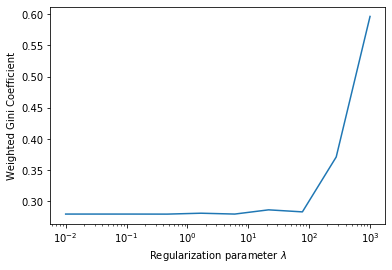

In [45]:
plt.plot(reg_params, plot)
plt.xlabel("Regularization parameter $\lambda$")
plt.xscale("log")
plt.ylabel("Weighted Gini Coefficient")
plt.show()

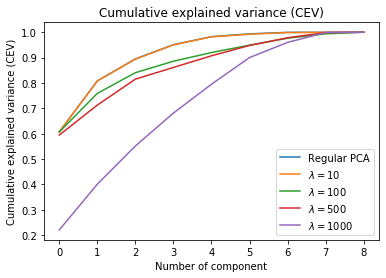

In [25]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular PCA")
reg_scot_10 = PCAObject(SCoT(X_small, 10, alpha = 10**-3), X_small, "$\lambda = 10$")
reg_scot_100 = PCAObject(SCoT(X_small, 100, alpha = 10**-3), X_small, "$\lambda = 100$")
reg_scot_500 = PCAObject(SCoT(X_small, 500, alpha = 10**-3), X_small, "$\lambda = 500$")
reg_scot_1000 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "$\lambda = 1000$")

reg_reg.plotCEV()
reg_scot_10.plotCEV()
reg_scot_100.plotCEV()
reg_scot_500.plotCEV()
reg_scot_1000.plotCEV()
plt.savefig("../Figures/SCoT_comparison.pdf", bbox_inches = 'tight')

In [ ]:
reg_reg.calcExpVar()
reg_scot_100.calcExpVar()
reg_scot_500.calcExpVar()
reg_scot_750.calcExpVar()
reg_scot_1000.calcExpVar()
reg_scot_5000.calcExpVar()
reg_scotlass_1.calcExpVar()
reg_scotlass_1pt2.calcExpVar()
reg_scotlass_1pt5.calcExpVar()
reg_scotlass_1pt6.calcExpVar()
reg_scotlass_2.calcExpVar()

#reg_reg.plotSparsitytoEV(0)
reg_scotlass_1.plotSparsitytoEV(0)
reg_scotlass_1pt5.plotSparsitytoEV(0)
reg_scotlass_1pt6.plotSparsitytoEV(0)
#reg_scotlass_2.plotSparsitytoEV(0)

In [ ]:
x = np.arange(len(reg_reg.pcs))

vm_reg = np.apply_along_axis(varimax, axis = 1, arr = reg_reg.pcs)
vm_scot = np.apply_along_axis(varimax, axis = 1, arr = reg_scot.pcs)

plt.plot(x, vm_reg, label = "regular")
plt.plot(x, vm_scot, label = "SCoT")
plt.xlabel('Number of component')
plt.ylabel('Varimax criterion')
plt.legend()
plt.title(' ')

In [ ]:
reg_spca_001 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "$\lambda = 1000$")


In [ ]:
np.sum(np.apply_along_axis(varimax, axis = 1, arr = reg_scotlass_14.pcs))

In [367]:
reg_reg_ord = list(reversed(np.argsort(abs(reg_reg.pcs[0]))))+np.ones(len(reg_reg.pcs[0]))

reg_scot_500_ord = list(reversed(np.argsort(abs(reg_scot_500.pcs[0]))))+np.ones(len(reg_scot_500.pcs[0]))
reg_scot_750_ord = list(reversed(np.argsort(abs(reg_scot_750.pcs[0]))))+np.ones(len(reg_scot_750.pcs[0]))
reg_scot_1000_ord = list(reversed(np.argsort(abs(reg_scot_1000.pcs[0]))))+np.ones(len(reg_scot_1000.pcs[0]))
reg_scot_5000_ord = list(reversed(np.argsort(abs(reg_scot_5000.pcs[0]))))+np.ones(len(reg_scot_5000.pcs[0]))

reg_scotlass_1_ord = list(reversed(np.argsort(abs(reg_scotlass_1.pcs[0]))))+np.ones(len(reg_scotlass_1.pcs[0]))
reg_scotlass_1pt2_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt2.pcs[0]))))+np.ones(len(reg_scotlass_1pt2.pcs[0]))
reg_scotlass_1pt5_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt5.pcs[0]))))+np.ones(len(reg_scotlass_1pt5.pcs[0]))
reg_scotlass_1pt6_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt6.pcs[0]))))+np.ones(len(reg_scotlass_1pt6.pcs[0]))
reg_scotlass_2_ord = list(reversed(np.argsort(abs(reg_scotlass_2.pcs[0]))))+np.ones(len(reg_scotlass_2.pcs[0]))

ordered_loadings = np.array([reg_reg_ord,
                    reg_scot_500_ord,
                    reg_scot_750_ord,
                    reg_scot_1000_ord,
                    reg_scot_5000_ord,
                    reg_scotlass_2_ord,
                    reg_scotlass_1pt5_ord,
                    reg_scotlass_1pt2_ord,
                    reg_scotlass_1_ord])

gini_coefs = np.array([reg_reg.gini[0],
              reg_scot_500.gini[0],    
              reg_scot_750.gini[0],             
              reg_scot_1000.gini[0],
              reg_scot_5000.gini[0],
              reg_scotlass_2.gini[0],
              reg_scotlass_1pt5.gini[0],                    
              reg_scotlass_1pt2.gini[0],
              reg_scotlass_1.gini[0]])

pevs = np.array([reg_reg.pev[0],
              reg_scot_500.pev[0],    
              reg_scot_750.pev[0],             
              reg_scot_1000.pev[0],
              reg_scot_5000.pev[0],
              reg_scotlass_2.pev[0],
              reg_scotlass_1pt5.pev[0],                    
              reg_scotlass_1pt2.pev[0],
              reg_scotlass_1.pev[0]])

gini_coefs = np.reshape(gini_coefs,(len(gini_coefs),1))

pevs = np.reshape(pevs,(len(pevs),1))

weighted_gini = gini_coefs * pevs

df_data = np.concatenate((gini_coefs, pevs, weighted_gini, ordered_loadings), 1)

In [101]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")

reg_scot_500 = PCAObject(SCoT(X_small, 500, alpha = 10**-3), X_small, "SCoT 500")
reg_scot_750 = PCAObject(SCoT(X_small, 750, alpha = 10**-3), X_small, "SCoT 750")
reg_scot_1000 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "SCoT 1000")
reg_scot_5000 = PCAObject(SCoT(X_small, 5000, alpha = 10**-3), X_small, "SCoT 5000")

reg_scotlass_1 = PCAObject(SCoTLASS(X_small,1,alpha = 10**-6, max_iter = 500000), X_small, "SCoTLASS 1")
reg_scotlass_1pt3 = PCAObject(SCoTLASS(X_small,1.3,alpha = 1.5*10**-6, max_iter = 500000), X_small, "SCoTLASS 1.3")
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,1.5,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS 1.5")
reg_scotlass_1pt6= PCAObject(SCoTLASS(X_small,1.6,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS 1.6")
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 2*10**-6, max_iter=1000000), X_small, "SCoTLASS 2")

reg_reg_ord = list(reversed(np.argsort(abs(reg_reg.pcs[0]))))+np.ones(len(reg_reg.pcs[0]))

reg_scot_500_ord = list(reversed(np.argsort(abs(reg_scot_500.pcs[0]))))+np.ones(len(reg_scot_500.pcs[0]))
reg_scot_750_ord = list(reversed(np.argsort(abs(reg_scot_750.pcs[0]))))+np.ones(len(reg_scot_750.pcs[0]))
reg_scot_1000_ord = list(reversed(np.argsort(abs(reg_scot_1000.pcs[0]))))+np.ones(len(reg_scot_1000.pcs[0]))
reg_scot_5000_ord = list(reversed(np.argsort(abs(reg_scot_5000.pcs[0]))))+np.ones(len(reg_scot_5000.pcs[0]))

reg_scotlass_1_ord = list(reversed(np.argsort(abs(reg_scotlass_1.pcs[0]))))+np.ones(len(reg_scotlass_1.pcs[0]))
reg_scotlass_1pt2_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt2.pcs[0]))))+np.ones(len(reg_scotlass_1pt2.pcs[0]))
reg_scotlass_1pt5_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt5.pcs[0]))))+np.ones(len(reg_scotlass_1pt5.pcs[0]))
reg_scotlass_1pt6_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt6.pcs[0]))))+np.ones(len(reg_scotlass_1pt6.pcs[0]))
reg_scotlass_2_ord = list(reversed(np.argsort(abs(reg_scotlass_2.pcs[0]))))+np.ones(len(reg_scotlass_2.pcs[0]))

ordered_loadings = np.array([reg_reg_ord,
                    reg_scot_500_ord,
                    reg_scot_750_ord,
                    reg_scot_1000_ord,
                    reg_scot_5000_ord,
                    reg_scotlass_2_ord,
                    reg_scotlass_1pt5_ord,
                    reg_scotlass_1pt2_ord,
                    reg_scotlass_1_ord])

gini_coefs = np.array([reg_reg.gini[0],
              reg_scot_500.gini[0],    
              reg_scot_750.gini[0],             
              reg_scot_1000.gini[0],
              reg_scot_5000.gini[0],
              reg_scotlass_2.gini[0],
              reg_scotlass_1pt5.gini[0],                    
              reg_scotlass_1pt2.gini[0],
              reg_scotlass_1.gini[0]])

pevs = np.array([reg_reg.pev[0],
              reg_scot_500.pev[0],    
              reg_scot_750.pev[0],             
              reg_scot_1000.pev[0],
              reg_scot_5000.pev[0],
              reg_scotlass_2.pev[0],
              reg_scotlass_1pt5.pev[0],                    
              reg_scotlass_1pt2.pev[0],
              reg_scotlass_1.pev[0]])

gini_coefs = np.reshape(gini_coefs,(len(gini_coefs),1))

pevs = np.reshape(pevs,(len(pevs),1))

weighted_gini = gini_coefs * pevs

#df_data = np.concatenate((gini_coefs, pevs, weighted_gini, ordered_loadings), 1)
rows = ['PCA',
        'SCoT (reg_param = 500)',
        'SCoT (reg_param = 750)',
        'SCoT (reg_param = 1000)',
        'SCoT (reg_param = 5000)',
        'SCoTLASS (reg_param = 2)',
        'SCoTLASS (reg_param = 1.5)',
        'SCoTLASS (reg_param = 1.2)',
        'SCoTLASS (reg_param = 1)']

cols = ['%d' %(i+1) for i in range(X_small.shape[1])]
ordered_load_df = pd.DataFrame(ordered_loadings,index = rows, columns = cols)

In [77]:
print('loadings:')
pd.DataFrame([np.around(reg_scotlass_2.pcs[i],2) for i in range(len(reg_scotlass_2.pcs))],columns=['var %d' % i for i in range(1,len(reg_scotlass_2.pcs)+1)])

loadings:


,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9
0,0.34,0.00,0.00,0.41,0.37,0.41,0.43,0.33,0.35
1,-0.15,0.69,0.67,-0.05,0.10,0.16,0.04,-0.03,-0.11
2,0.71,0.08,0.26,-0.00,0.00,-0.60,-0.15,0.00,0.20
3,-0.18,0.09,0.00,0.00,-0.20,-0.00,-0.49,0.79,0.25
4,-0.08,0.12,-0.01,-0.00,-0.48,0.17,0.00,-0.39,0.75
5,0.22,0.64,-0.67,-0.29,0.10,0.05,-0.00,0.01,-0.03
6,0.01,-0.20,0.16,-0.81,0.00,-0.00,0.44,0.25,0.16
7,0.00,0.16,-0.06,0.26,-0.65,-0.23,0.55,0.24,-0.27
8,-0.52,0.13,-0.11,0.14,0.39,-0.61,0.24,0.01,0.32


In [360]:
print('loadings:')
pd.DataFrame([np.around(reg_reg.pcs[i],2) for i in range(len(reg_reg.pcs))],columns=['var %d' % i for i in range(1,len(reg_reg.pcs)+1)])

loadings:


,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9
0,0.39,-0.05,0.09,0.40,0.35,0.35,0.39,0.36,0.39
1,-0.24,0.66,0.59,-0.06,0.17,0.28,0.10,-0.09,-0.18
2,-0.22,0.33,-0.48,0.31,0.29,-0.02,-0.31,0.49,-0.32
3,-0.13,-0.09,-0.44,-0.34,0.48,0.49,0.11,-0.42,-0.03
4,-0.26,-0.57,0.42,0.06,0.53,-0.21,-0.04,0.09,-0.30
5,0.08,-0.19,0.22,-0.08,-0.11,0.53,-0.75,0.14,0.16
6,-0.39,-0.28,-0.03,0.28,-0.49,0.46,0.34,0.09,-0.33
7,-0.00,0.03,-0.01,0.73,0.06,-0.04,-0.23,-0.63,0.06
8,-0.71,0.00,-0.02,0.01,0.02,-0.10,0.00,0.09,0.69


In [357]:
np.degrees(np.arccos(reg_reg.pcs[0] @ reg_scotlass_2.pcs[0]))

8.224363045918498

| Variable | Variable description |
| --- | --- |
| x1 | I0 - Impedivity (ohm) at zero frequency
| x2 | PA500 - phase angle at 500 KHz
| x3 | HFS - high-frequency slope of phase angle
| x4 | DA - impedance distance between spectral ends
| x5 | AREA - area under spectrum
| x6 | A/DA - area normalized by DA
| x7 | MAX IP - maximum of the spectrum
| x8 | DR - distance between I0 and real part of the maximum frequency point
| x9 | P - length of the spectral curve

In [366]:
print('loadings:')
loading_data = np.around([reg_reg.pcs[0],
        reg_scot_500.pcs[0],
        reg_scot_1000.pcs[0],
        reg_scotlass_1.pcs[0],
        reg_scotlass_2.pcs[0]],2)

index = ["PCA","SCoT (reg_param = 500)","SCoT (reg_param = 1000)","SCoTLASS (reg_param = 1)","SCoTLASS (reg_param = 2)"]
pd.DataFrame(loading_data,index = index, columns=['var %d' % i for i in range(1,len(reg_scotlass_2.pcs)+1)])

loadings:


,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9
PCA,0.39,-0.05,0.09,0.40,0.35,0.35,0.39,0.36,0.39
SCoT (reg_param = 500),0.35,-0.01,0.07,0.44,0.31,0.34,0.49,0.30,0.37
SCoT (reg_param = 1000),0.03,-0.00,0.01,0.04,0.03,0.04,1.00,0.03,0.04
SCoTLASS (Reg_param = 1),0.00,-0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
SCoTLASS (reg_param = 2),0.34,0.00,0.00,0.41,0.37,0.41,0.43,0.33,0.35


In [456]:
# Function for calculating adjusted variance of SPCA principal components
def Adj_Var(X,PCs):
    adj_EVs = []
    X_prior = np.zeros((X.shape[1],X.shape[1]))
    for i in range(0,len(PCs)):
        V = np.reshape(np.array([PCs[j] for j in range(i+1)]),(i+1,len(PCs[i])))
        X_k = X @ V.T @ np.linalg.inv(V @ V.T) @ V
        adj_EV_k = (np.trace(X_k.T@X_k) - np.trace(X_prior.T @ X_prior))/(X.shape[0]-1)
        adj_EVs.append(adj_EV_k)
        X_prior = X_k
    return np.array(adj_EVs)

In [457]:
X = StandardScaler().fit_transform(X_small)

Adj_Var(X,spca_001_comp)

array([3.34233165, 1.48141666, 0.34285592, 0.85848801, 0.42466901,
       0.21799953, 0.45957218, 0.94885753, 1.00952381])

In [ ]:
spca_0005 = SparsePCA(n_components = 9, alpha = 0.005, ridge_alpha = 0.01)
spca_001 = SparsePCA(n_components = 9, alpha = 0.01, ridge_alpha = 0.01)
spca_0015 = SparsePCA(n_components = 9, alpha = 0.015, ridge_alpha = 0.01)
spca_002 = SparsePCA(n_components = 9, alpha = 0.02, ridge_alpha = 0.01)
spca_0025 = SparsePCA(n_components = 9, alpha = 0.025, ridge_alpha = 0.01)

spca_0005.fit(X)
spca_001.fit(X)
spca_0015.fit(X)
spca_002.fit(X)
spca_0025.fit(X)

spca_0005_comp = np.array(i/np.linalg.norm(i) for i in spca_0005.components_)
spca_001_comp = [i/np.linalg.norm(i) for i in spca_001.components_]
spca_0015_comp = [i/np.linalg.norm(i) for i in spca_0015.components_]
spca_002_comp = [i/np.linalg.norm(i) for i in spca_002.components_]
spca_0025_comp = [i/np.linalg.norm(i) for i in spca_0025.components_]
